Markov modelling with PyEMMA - Part 2: MSM estimation and (some) analysis
=====

In this tutorial notebook we will give a brief overview of some of PyEMMA's capabilities by analyzing MD simulations of a Pentapeptide. In this notebook the first session is continued. You will learn how to select a lag time using the implied timescales plot, estimate and Markov model and how to test the Markov model. Please go through the notebook and complete #FIXME-comments noted below TODO sections.

Now we import the PyEMMA modules required for the following steps.

In [1]:
import numpy as np
import pyemma
import mdshare
import shortcuts_penta as shortcuts
import matplotlib.pyplot as plt
%matplotlib inline

/Users/fab/miniconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.1, you have 2.5.
  .format(latest=latest, current=current), category=UserWarning)


Do all the preprocessing from part I (featurization, TICA, clustering)
------

This was already done in part I. We need to run the commands below in order to have the data in this notebook:

In [2]:
topfile = mdshare.load('pentapeptide-impl-solv.pdb')
traj_list = [mdshare.load('pentapeptide-%02d-500ns-impl-solv.xtc' % i) for i in range(25)]
feat = pyemma.coordinates.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
feat.add_sidechain_torsions(cossin=True)
inp = pyemma.coordinates.source(traj_list, feat)
tica_obj = pyemma.coordinates.tica(inp, lag=20)
Y = tica_obj.get_output()
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
clustering = pyemma.coordinates.cluster_kmeans(Y, k=250, max_iter=100)
dtrajs = clustering.dtrajs
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

19-02-18 14:48:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 10 steps.


A Jupyter Widget

Let's check if everything is OK. This will show the cluster center locations like in part I:

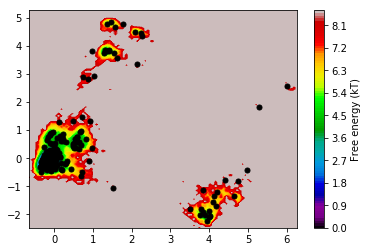

In [3]:
pyemma.plots.plot_free_energy(xall, yall)
plt.plot(cc_x, cc_y, linewidth=0, marker='o', markersize=5, color='black')

Selecting a lag time with the implied timescales plot
-----

The quality and the practical usefulness of a Markov model depend on two main parameters:

1. The state-space discretization, i.e. which steps we have conducted before (choice of coordinates, projection method, clustering method)
2. The lag time, i.e. at what time interval do we count transitions.

(1) has already been dealt with in part I. Here we select the lag time which is extremely important, and we should scan it in order to make an appropriate selection. So let us compute the so-called implied timescales, or relaxation timescales of the Markov model at different lag times.

##### TODO:

From the discrete trajectories that are already loaded into the variable `dtrajs`,
compute the largest 10 implied time scales for all times up to 200 steps. Save the resulting object in the variable ``its``.


In [4]:
its = pyemma.msm.its(dtrajs, nits=10, lags=200) # FIXME!

A Jupyter Widget

What this function does is to estimate a Markov model at each of the given lag times $\tau$ (that are multiples of our saving step), compute the eigenvalues of each transition matrix, $\lambda_i(\tau)$, and then compute the relaxation timescales according to:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}$$
The its object will mainly give us these estimated timescales. We can simply use the resulting object (its) in the appropraite plotting function:

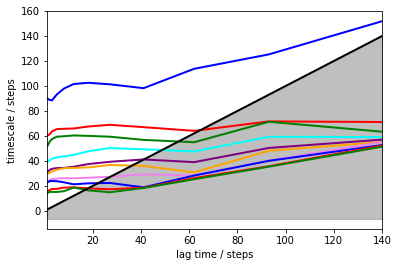

In [5]:
pyemma.plots.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)

It has been shown [3] that these timescales should be independent of the lag time. You can see that for short lag times this is not the case, but after about 15 steps, they are pretty constant. The faster timescales still increase. Part of this is normal and due to numerical issues. 

In a nutshell: longer lagtimes are better, at least as long you stay away from the grey area. The grey area is defined by lag > timescale, and in this area we cannot make a reliable estimate because the process under investigation has already decayed. Everything within or close to the grey area is distorted.

Of course looking at a plot and judging the flatness by eye is not really sophisticated. Especially because the error bars on these timescales can be pretty big. 

#### TODO:
Compute an implied timescales object with error information and plot again. These implied time scales can be computed using the same pyemma function, that you already used above to compute the implied time scales without error. Check the documentation of that function and look for the optional parameter `errors`.

In [6]:
its_bayes = pyemma.msm.its(dtrajs, nits=10, lags=200, errors='bayes') # FIXME!

A Jupyter Widget

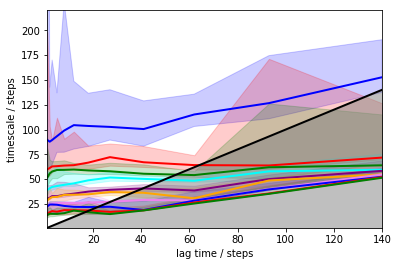

In [7]:
pyemma.plots.plot_implied_timescales(its_bayes, show_mean=False, ylog=False, units='steps', linewidth=2)
plt.ylim(1,220);

You see that in order to be constant within the error bars, we could even use shorter lag times. But let's go with 12 for now. 

## Estimating a MSM 

Now we can finally estimate a Markov model. In fact we have already estimated several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering (`dtrajs`) and the lag time:

##### TODO:
Please go ahead and estimate a Markov model with a lag of 12 steps and save it in ``M``.

In [10]:
M = pyemma.msm.estimate_markov_model(dtrajs, lag=12) # FIXME!

The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [11]:
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


Spectral analysis and Champman-Kolmogovov test
-----------

Let us have a closer look at the timescales that were already seen in the implied timescales plot.

##### TODO
For this, compute the 20 leading implied time scales of the Markov model ``M`` and save them in the variable ``timescales_msm``.

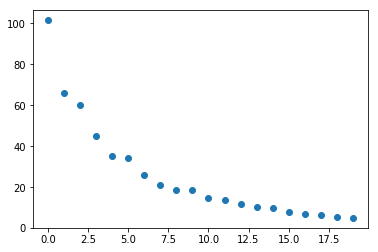

In [13]:
timescales_msm = M.timescales(20) # FIXME!
plt.plot(timescales_msm, linewidth=0, marker='o')

Can you see that there is a large timescale separation between the first and the second timescale? And between the third and fourth timescale? This means that if we are interested in coarse-graining our dynamics, retaining one  timescale (in a model with two metastable states), or three timescales (in a model with four metastable states) is a good choice.

Implied timescales can help to make the lag time decision, but they are not very strong tests of the validity of the model, because they only look at eigenvalues, while there is a lot of information in the eigenvectors. The Chapman-Kolmogorov Test is much stronger. In PyEMMA we have generalized the concept of the Chapman-Kolmogorov Test in order to be able to test various different models. The idea is: given a model estimated at lag time $\tau$, let’s make a prediction of a model quantity for lag time $k \tau$, and let’s compare that to an independently estimated a model at $k \tau$. The standard ``cktest`` computes the transition probability between metastable states for different lag times.

#### TODO:
Compute the Chapman-Kolmogorov test and save the test results in the variable ``ck``. For the Chapman-Kolmogorov test you will need to select a number of metastable sets. Pick a number of metastable sets based on what you have observed above in the implied time scale plot. 

In [16]:
ck = M.cktest(4) # FIXME!

A Jupyter Widget

Lets plot the test results to see if predictions and estimates at higher lagtimes agree.

(<matplotlib.figure.Figure at 0x10359def0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x111eb63c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12bd88198>], dtype=object))

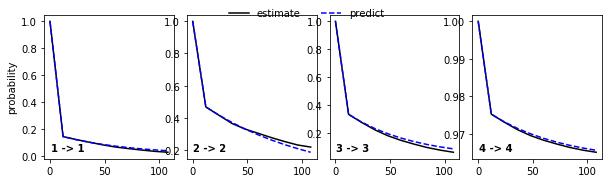

In [17]:
pyemma.plots.plot_cktest(ck, diag=True, y01=False, units='steps')

Like the convergence of the implied timescales, agreement between predicted and estimated transition probabilities can only be judged properly, if the error bars of the estimates and the predictions are known. So let's repeat the Chapman-Kolmogorov test but this time with a Bayesian Markov model that contains information about statisitical variability.

#### TODO:

* From the discrete trajectories ``dtrajs``, estimate a Bayesian Markov model at a lag time of 12 steps and save the resulting object in the variable ``M_bayes``.
* Use the ``cktest`` method of ``M_bayes`` to repeat the Chapman-Kolmogorov test and store the resulting object in ``ck_bayes``.

In [18]:
M_bayes = pyemma.msm.bayesian_markov_model(dtrajs=dtrajs, lag=40) # FIXME!

A Jupyter Widget

In [ ]:
ck_bayes = M_bayes.cktest(4) # FIXME!

A Jupyter Widget

(<matplotlib.figure.Figure at 0x1151f9518>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1151ce940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x142f21f98>], dtype=object))

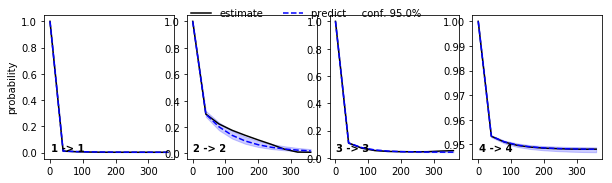

In [21]:
pyemma.plots.plot_cktest(ck_bayes, diag=True, y01=False, units='steps')

Finally, let us look at the right eigenvectors of the Markov model.




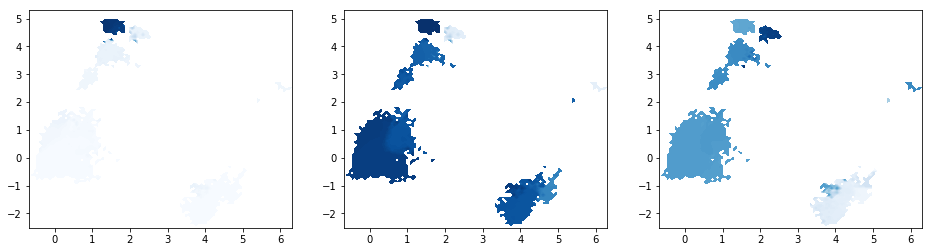

In [22]:
# project eigenvectors
proj_ev_all = [np.hstack([M.eigenvectors_right()[:,i][dtraj] for dtraj in M.discrete_trajectories_full]) 
               for i in range(1, 10)]
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    shortcuts.plot_sampled_function(xall, yall, proj_ev_all[i], ax=ax, cbar=False, cmap=plt.cm.Blues)

Clearly, the slow processes involve transitions into/out of the different free energy minima that are already apparent in the projection of the data onto the first and second TICA dimension. This is great news for TICA, because it means that even before computing a Markov model we have done a good job at finding slow order parameters. However only by clustering the TICA space and estimating an MSM, we can automatically separate the individual free energy minima.

Let's Play
-------

So far we only looked at the first, second and third kinetic process. What about the thermodynamics of the model?
1. Can you plot the stationary distribution across the cluster centers in the same way you have been looking at the second and third eigenvector?
2. Can you estimate a second MSM using a different lagtime? What would be a valid other lagimte choice? How much does the stationary probability change? Can you find a good way of comparing the two stationary probabilities?
3. You can also generate a new trajectory from your transition matrix. The last challange is to generate a new trajectory use this trajectory to estimate a new MSM and then compare it to the original one you had. What do you need to consider with respect to the lagtime. Make sure you read all the documentation provided with these functions. If you don't understand them ask. 

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Pérez-Hernández, G. and Paul, F. and Giorgino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
3. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
4. Susanna Röblitz Marcus Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv Data Anal Classif (2013), DOI 10.1007/s11634-013-0134-6
5. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
6. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
7. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)